# Access harmonized LUCAS samples

## Install 
### Note for Google Colab

In the case that this notebook is run in [Google Colab](https://colab.research.google.com/), additional steps are needed. Google Colab comes with GDAL 2.2. We have to update this library to version 3.0. It will takes a while.

In [ ]:
!add-apt-repository --yes ppa:ubuntugis/ubuntugis-unstable
!apt update
!apt install libgdal26
!pip install gdal==3.0.4
print("INSTALLATION COMPLETED")

### Install st_lucas package

First of all, let's install [st_lucas](https://pypi.org/project/st-lucas/) Python package and additional required packages.

In [ ]:
!pip install st_lucas ipyleaflet

Now **we have to restart runtime**: `Runtime -> Restart runtime` (on Google Colab) or ``Kernel -> Restart`` (on JupyterLab).

From `st_lucas` package let's import `LucasRequest` and `LucasIO`.

In [2]:
from st_lucas import LucasRequest, LucasIO

## Usage

### Define a request

Request is defined by `LucasRequest`. In example below the spatial filter is defined by a bounding box (`bbox` property). Note that only [EPSG:3035](http://epsg.io/3035) is supported.

For testing purposes, the request can be created by `build()` method.

In [3]:
request = LucasRequest()
request.bbox = (4504276, 3020369, 4689608, 3105290)

request.build()

{'typename': 'lucas:lucas_points',
 'filter': '<ogc:BBOX xmlns:ogc="http://www.opengis.net/ogc"><ogc:PropertyName>geom</ogc:PropertyName><gml311:Envelope xmlns:gml311="http://www.opengis.net/gml" srsName="http://www.opengis.net/gml/srs/epsg.xml#3035"><gml311:lowerCorner>4504276 3020369</gml311:lowerCorner><gml311:upperCorner>4689608 3105290</gml311:upperCorner></gml311:Envelope></ogc:BBOX>'}

### Download data based on a request

LUCAS data retrieval is controlled by the `LucasIO` (input/output) class. Data is downloaded by calling the `download()` method using the prepared request. The number of downloaded LUCAS observations can be retrived by the `count()` method.

In [4]:
lucasio = LucasIO()
lucasio.download(request)

print("Number of downloaded points:", lucasio.count())

2024-03-09 23:42:58,268 - root - WARNING - __init__.getSRS - Requested srsName 'EPSG:3035' is not declared as being allowed for requested typename 'lucas:lucas_points'. Options are: 'urn:x-ogc:def:crs:EPSG:3035'.
2024-03-09 23:42:59,070 - LUCAS - INFO - io.download - Download process successfuly finished. Size of downloaded data: 14258kb


Warning 1: GDAL was built against curl 8.6.0, but is running against 8.5.0. Runtime failure is likely !


Number of downloaded points: 5222


### Get data in specified format

`LucasIO` allows getting data in various data structures/formats.

By calling the `to_geopandas()` method, the data is retrieved as a [GeoDataFrame](https://geopandas.org/docs/reference/api/geopandas.GeoDataFrame.html) object.

We can visualize downloaded LUCAS observations using `ipyleaflet` package.

In [5]:
from ipyleaflet import Map, GeoData, basemaps, LayersControl

points = lucasio.to_geopandas(epsg=4326)

center = points.dissolve().centroid
m = Map(center=(float(center.y), float(center.x)), zoom=8, basemap=basemaps.OpenStreetMap.Mapnik)

geo_data = GeoData(geo_dataframe=points,
                   style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.05, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
                   point_style={'radius': 2, 'color': 'red', 'fillOpacity': 0.8, 'fillColor': 'blue', 'weight': 3},
                   name='LUCAS points')

m.add_layer(geo_data)
m.add_control(LayersControl())

m

2024-03-09 23:43:01,425 - numexpr.utils - INFO - utils._init_num_threads - Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-03-09 23:43:01,426 - numexpr.utils - INFO - utils._init_num_threads - NumExpr defaulting to 8 threads.


/tmp/ipykernel_130678/3023446211.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = points.dissolve().centroid
/tmp/ipykernel_130678/3023446211.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  m = Map(center=(float(center.y), float(center.x)), zoom=8, basemap=basemaps.OpenStreetMap.Mapnik)


Map(center=[50.622378142703965, 13.883115355389979], controls=(ZoomControl(options=['position', 'zoom_in_text'…

The method `to_gml()` returns a byte array containing data in the [OGC GML](https://www.ogc.org/standards/gml) format.

In [6]:
gml_str = lucasio.to_gml()

# check the type of the string
print(type(gml_str), '\n'.join(gml_str.splitlines()[:5]))

<class 'str'> <?xml version="1.0" encoding="utf-8" ?>
<ogr:FeatureCollection
     gml:id="aFeatureCollection"
     xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
     xsi:schemaLocation="http://ogr.maptools.org/ st_lucas_jtg7jf2l.xsd"


The method `to_gpkg()` stores the data locally in a [OGC GeoPackage](https://www.geopackage.org/) file.

In [7]:
gpkg_file = 'sample.gpkg'
lucasio.to_gpkg(gpkg_file)

# check if the file exists
from pathlib import Path
print(Path(gpkg_file).exists())

True


## Request examples

Beside filtering by a bounding box, `LucasRequest` also supports other two spatial filters: 
* by countries and
* by user-defined polygon

### Filter by countries

List of countries to be filtered is defined by `countries` property. Country is given by NUTS0 code. In the example below the spatial filter is limited to the Czech Republic. LUCAS subset is downloaded by user-defined `download()` function.

In [8]:
request = LucasRequest() 
request.countries = ['CZ']

def download(request):
    lucasio = LucasIO()
    lucasio.download(request)
    print("Number of downloaded points:", lucasio.count())
    
download(request)

2024-03-09 23:43:19,165 - root - WARNING - __init__.getSRS - Requested srsName 'EPSG:3035' is not declared as being allowed for requested typename 'lucas:lucas_points'. Options are: 'urn:x-ogc:def:crs:EPSG:3035'.
2024-03-09 23:43:22,870 - LUCAS - INFO - io.download - Download process successfuly finished. Size of downloaded data: 74649kb
Number of downloaded points: 27227


Example below demostrate retrival of LUCAS subset defined by the Czech Republic and Slovakia.

In [9]:
request = LucasRequest()
request.countries = ['CZ', 'SK']

download(request)

2024-03-09 23:43:34,646 - root - WARNING - __init__.getSRS - Requested srsName 'EPSG:3035' is not declared as being allowed for requested typename 'lucas:lucas_points'. Options are: 'urn:x-ogc:def:crs:EPSG:3035'.
2024-03-09 23:43:44,259 - LUCAS - INFO - io.download - Download process successfuly finished. Size of downloaded data: 112898kb
Number of downloaded points: 41618


### Filter by polygon

Spatial filter can be also defined by polygon vertices. 

There is a limit for the request length, so the number of vertices is also limited. The AOI polygon can contain only about 190 vertices.

In [10]:
request = LucasRequest()
request.aoi_polygon = '''
<Within>
    <PropertyName>lucas:geom</PropertyName>' \
    <gml:Polygon xmlns:gml="http://www.opengis.net/gml" srsName="urn:ogc:def:crs:EPSG::3035" gml:id="polygon_32.geom.0">' \
        <gml:exterior>' \
            <gml:LinearRing>' \
                 <gml:posList>3014669.3195414557 4640226.080241454 2981893.140187475 4628385.701013993 2965449.7283930806 4639492.816821902 2958781.6185918115 4658392.1858341275 2977549.274784839 4672892.4477362465 3004572.819247867 4661017.510044226 3014669.3195414557 4640226.080241454 </gml:posList>' \
             </gml:LinearRing>' \
         </gml:exterior>' \
    </gml:Polygon>' \
</Within>
'''

download(request)

2024-03-09 23:44:01,896 - root - WARNING - __init__.getSRS - Requested srsName 'EPSG:3035' is not declared as being allowed for requested typename 'lucas:lucas_points'. Options are: 'urn:x-ogc:def:crs:EPSG:3035'.
2024-03-09 23:44:02,136 - LUCAS - INFO - io.download - Download process successfuly finished. Size of downloaded data: 1518kb
Number of downloaded points: 554


### Filter by years

By default all survey years are retrieved. By the `years` property, list of survey years can be limited.

In [11]:
request = LucasRequest()
request.countries = ['AT']
request.years = [2006, 2009]

download(request)

2024-03-09 23:44:02,826 - root - WARNING - __init__.getSRS - Requested srsName 'EPSG:3035' is not declared as being allowed for requested typename 'lucas:lucas_points'. Options are: 'urn:x-ogc:def:crs:EPSG:3035'.
2024-03-09 23:44:03,611 - LUCAS - INFO - io.download - Download process successfuly finished. Size of downloaded data: 11222kb
Number of downloaded points: 4961


### Thematic groups

A thematic group determines which attributes will describe the downloaded data. There are 5 groups:
* `LC_LU` - Land cover, Land use;
* `LC_LU_SO` - Land cover, Land use, Soil);
* `CO` - Copernicus;
* `FO` - Forestry;
* `IN` - INSPIRE.

Visit [list of LUCAS attributes](https://geoforall.fsv.cvut.cz/st_lucas/tables/list_of_attributes.html) on ST_LUCAS website.

The file always contains mandatory attributes that define mainly the location of the point.

A combination of `bbox` and `group` (Copernicus) is presented below.

In [12]:
request = LucasRequest()
request.countries = ['CZ']
request.group = 'CO'

lucasio = LucasIO()
lucasio.download(request)

points = lucasio.to_geopandas()
print("Number of attributes:", len(points.columns))

2024-03-09 23:44:06,105 - root - WARNING - __init__.getSRS - Requested srsName 'EPSG:3035' is not declared as being allowed for requested typename 'lucas:lucas_points_co'. Options are: 'urn:x-ogc:def:crs:EPSG:3035'.
2024-03-09 23:44:08,340 - LUCAS - INFO - io.download - Download process successfuly finished. Size of downloaded data: 31995kb
Number of attributes: 42


### Filter by attributes

Attribute filter allows to use any LUCAS attribute (see [list of LUCAS attributes](https://geoforall.fsv.cvut.cz/st_lucas/tables/list_of_attributes.html)) or combination of attributes.

In example bellow only LUCAS locations visited repeatedly 5 times are retrieved.

In [13]:
from owslib.fes import PropertyIsEqualTo

request = LucasRequest()
request.bbox = (4504276, 3020369, 4689608, 3105290)
request.propertyname = 'SURVEY_COUNT'
request.operator = PropertyIsEqualTo
request.literal = 5
request.st_aggregated = True

download(request)

2024-03-09 23:44:31,290 - root - WARNING - __init__.getSRS - Requested srsName 'EPSG:3035' is not declared as being allowed for requested typename 'lucas:lucas_st_points'. Options are: 'urn:x-ogc:def:crs:EPSG:3035'.
2024-03-09 23:44:31,721 - LUCAS - INFO - io.download - Download process successfuly finished. Size of downloaded data: 3011kb
Number of downloaded points: 199


### Space-time aggregation

The `st_aggregated` property is used to determine whether the data should be space-time aggregated. Space-time aggregation means that one record in the attribute table represents one point with all values measured in all years. Otherwise, every single record in the attribute table represents one survey.

In example below space-time aggregated LUCAS points located in the Czech Republic are queried.

In [14]:
request = LucasRequest()
request.group = 'LC_LU'
request.countries = ['CZ']
request.st_aggregated = True

lucasio = LucasIO()
lucasio.download(request)

points = lucasio.to_geopandas()
points.columns

2024-03-09 23:44:32,665 - root - WARNING - __init__.getSRS - Requested srsName 'EPSG:3035' is not declared as being allowed for requested typename 'lucas:lucas_st_points_lc_lu'. Options are: 'urn:x-ogc:def:crs:EPSG:3035'.
2024-03-09 23:44:36,715 - LUCAS - INFO - io.download - Download process successfuly finished. Size of downloaded data: 65435kb


Index(['point_id', 'nuts0', 'nuts1_2006', 'nuts1_2009', 'nuts1_2012',
       'nuts1_2015', 'nuts1_2018', 'nuts2_2006', 'nuts2_2009', 'nuts2_2012',
       ...
       'ex_ante_2015', 'ex_ante_2018', 'survey_count', 'survey_dist_2006',
       'survey_dist_2009', 'survey_dist_2012', 'survey_dist_2015',
       'survey_dist_2018', 'survey_maxdist', 'geometry'],
      dtype='object', length=360)

In example below space-time aggregated LUCAS points only for years 2015 and 2018 are queried.

In [15]:
request = LucasRequest()

request.years = [2015, 2018]
request.bbox=(4624127, 2998330, 4650393, 3013986)
request.st_aggregated = True

download(request)

2024-03-09 23:48:49,146 - root - WARNING - __init__.getSRS - Requested srsName 'EPSG:3035' is not declared as being allowed for requested typename 'lucas:lucas_st_points'. Options are: 'urn:x-ogc:def:crs:EPSG:3035'.
2024-03-09 23:48:49,391 - LUCAS - INFO - io.download - Download process successfuly finished. Size of downloaded data: 432kb
Number of downloaded points: 54


### Show photos of selected LUCAS point

Show `point_id` of points by GeoPandas library.

In [16]:
request = LucasRequest()

request.years = [2015, 2018]
request.bbox=(4624127, 2998330, 4650393, 3013986)

lucasio = LucasIO()
lucasio.download(request)

df = lucasio.to_geopandas()
df[["point_id"]]

2024-03-09 23:48:51,969 - root - WARNING - __init__.getSRS - Requested srsName 'EPSG:3035' is not declared as being allowed for requested typename 'lucas:lucas_points'. Options are: 'urn:x-ogc:def:crs:EPSG:3035'.
2024-03-09 23:48:52,091 - LUCAS - INFO - io.download - Download process successfuly finished. Size of downloaded data: 257kb


point_id
0   46283000
1   46423000
2   46463000
3   46363012
4   46363000
..       ...
58  46343004
59  46403006
60  46343006
61  46383004
62  46323002

[63 rows x 1 columns]

#### Display photos

Show photos of a selected LUCAS point by calling the method `get_images()` with `year` and `point_id` of the point specified. This will return a dictionary of URL adresses of 5 photos representing the point itself, a northern look, a southern look, an eastern look, and a western look.

In [17]:
id = df[["point_id"]].values[0][0]
images = lucasio.get_images(2015, id)

Let's display photo representing the South of the point.

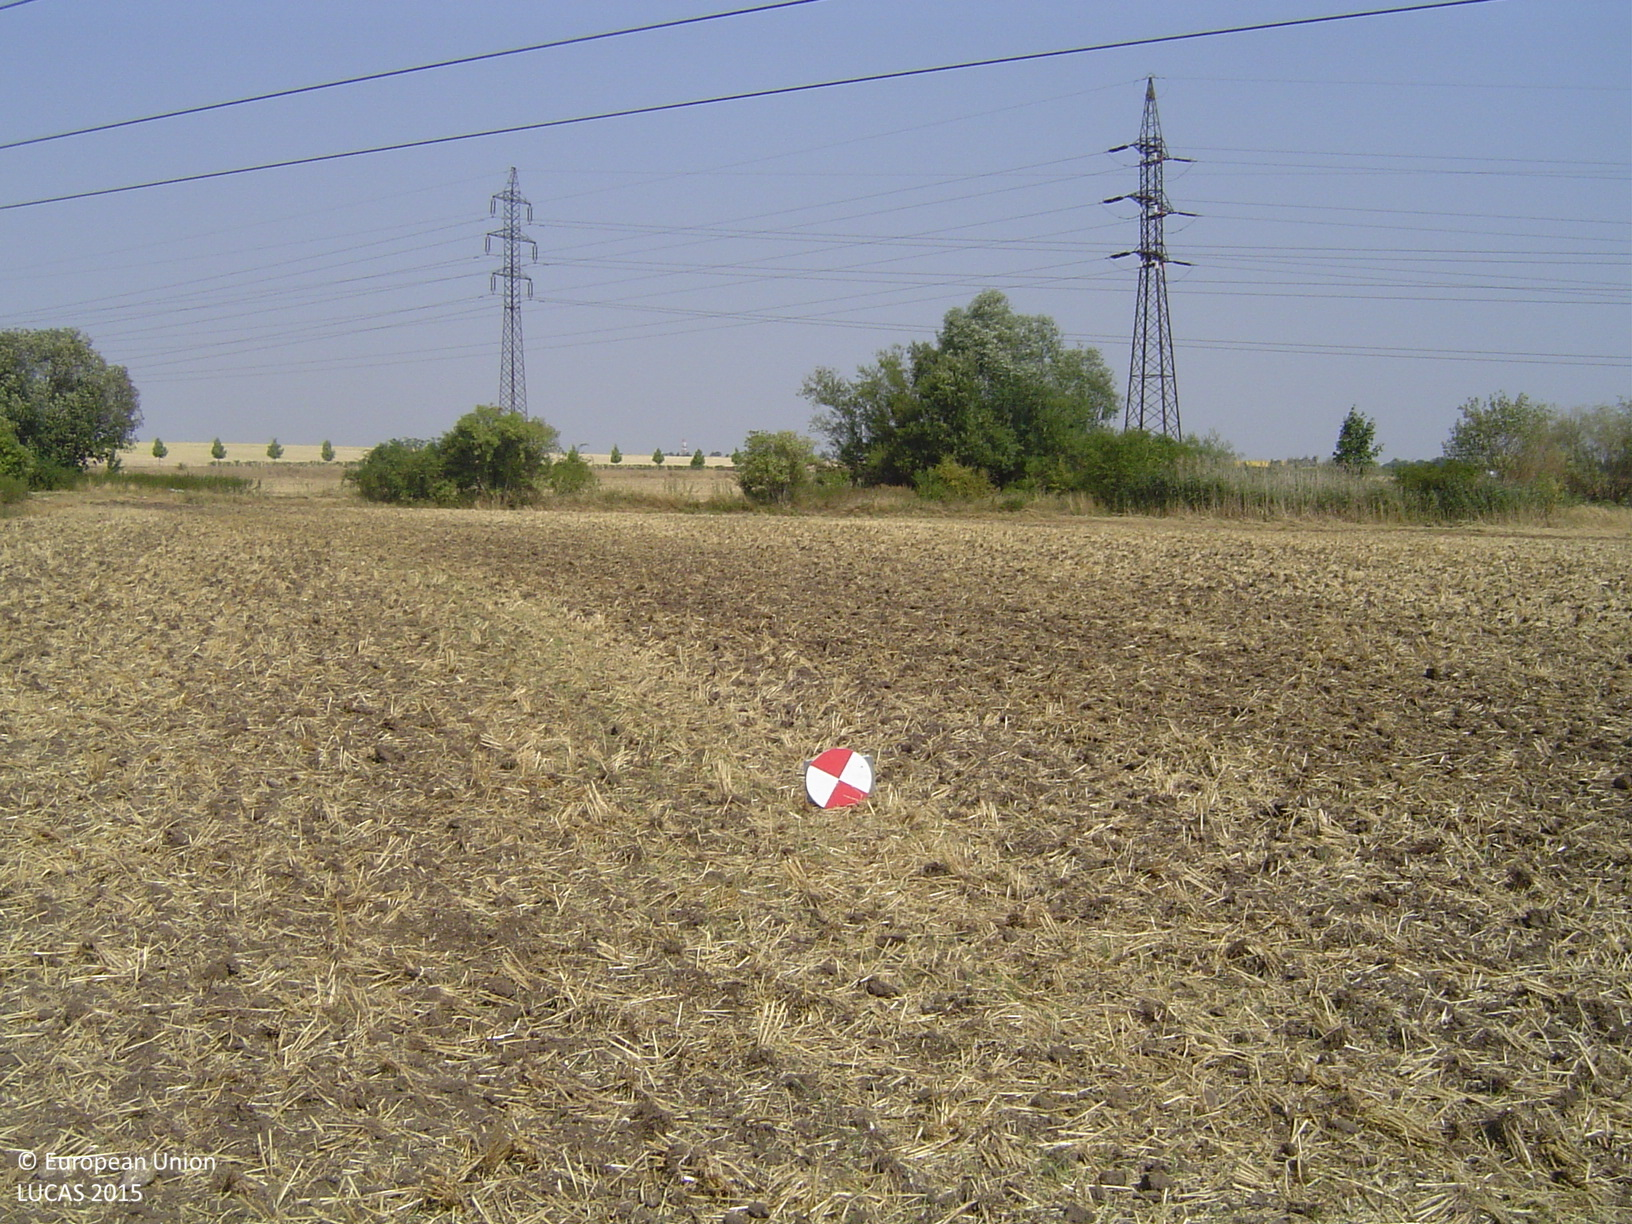

In [18]:
import requests
from IPython.display import Image

r = requests.get(images["P"])
Image(r.content)

#### Download photos

LUCAS photos may be downloaded by `download_images()` method. The method returns the path to the created zip archive with photos.

In [19]:
filename = lucasio.download_images(images, "/tmp")

2024-03-09 23:49:04,587 - LUCAS - INFO - io.download_images - LUCAS photos downloaded to: /tmp/46283000_2015.zip


Let's check downloaded zip archive.

In [20]:
from zipfile import ZipFile

print(filename)
with ZipFile(filename) as fd:
    print(fd.namelist())

/tmp/46283000_2015.zip
['P.jpg', 'S.jpg', 'N.jpg', 'E.jpg', 'W.jpg']
